# Real data experiments

We perform real data experiments on the Imagenet and MSCOCO datasets, for controlling risk metrics of various classifiers. These experiments have identical setup to the experiments in [Distribution-Free, Risk-Controlling Prediction Sets](https://arxiv.org/abs/2101.02703).

## Imagenet

Imagenet examples consist of an image $x \in \mathcal{X}$ that is paired with a single correct class $y \in \mathcal{Y}$.

Our loss is defined as follows for a label set $S$, and the corresponding true label $y$ is as follows:

$$ L(y, S) := L_y \mathbf{1}_{\left\{y \not\in S\right\}},$$

where $L_y \in \mathbb{R}^+$ denotes a user chosen penalty weight specifically for class $y$.

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y \in \mathcal{Y}: \mathbf{p}(x)_y \geq \beta \right\},$$
where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set.

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [1]:
def load_data(data_dir):
    import load_data
    return load_data.load_imagenet_torch_preds(data_dir)

In [7]:
data_dir = 'data/imagenet'
scores, labels = load_data(data_dir)
scores.shape, labels.shape

((50000, 1000), (50000,))

In [34]:
class WeightedCoverage(object):
    def __init__(self, w=None):
        import numpy as np
    
        super().__init__()
        self.w = w if w is not None else np.ones(1000)

    def __call__(self, PXY, betas):
        import numpy as np
        (P, _), Y = PXY
        return 1 - (betas <= np.array(P))[Y]

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y

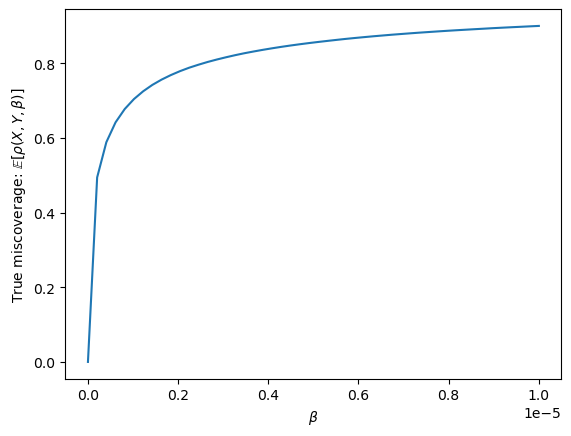

In [42]:
def plot_true_rho():
    import matplotlib.pyplot as plt
    import numpy as np
    
    rho = WeightedCoverage()
    betas = np.linspace(0.0, 0.00001, 50)
    
    risks = [np.mean(rho(((scores, None), labels), beta)) for beta in betas]
    fig, ax = plt.figure(), plt.gca()
    ax.plot(betas, risks), ax.set_xlabel('$\\beta$'), ax.set_ylabel('True miscoverage: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
plot_true_rho()

In [45]:

    
%matplotlib inline
def test_once(seed):
    from IwUpperMartingale import FullIwUpperMartingale, PartialIwUpperMartingale, FullyObservedUpperMartingale, ShiftedIwUpperMartingale
    from OnlineMinimax import OnlineMinimax, WindowedBeTheLeader
    from LogisticRegression import MultilabelRegressor
    import numpy as np
    import torch
    
    if True:
        torch.manual_seed(seed)
        np.set_printoptions(2, floatmode='fixed')

        rho = WeightedCoverage()
        theta = 1/12
        q_min = 1/10
        target_rate = 1/3

        knots = np.linspace(0, 1, 10)
        def featurize(probs):
            p = probs[probs > 0] * np.log(1 / probs[probs > 0])
            rv = [0]*len(knots)

            if p >= knots[-1]:
                rv[-1] = 1
            else:
                z = np.digitize(p, knots)
                vlow, vhigh = knots[z-1], knots[z]
                frac = (p - vlow) / (vhigh - vlow)
                rv[z] = frac
                rv[z - 1] = 1 - frac

            return rv

        def makeMinimax(policy, lr, q_min, target_rate, iwmart):
            from player import LabellingPolicyPrimalPlayer
            betastar = 1 - np.sqrt(2 * theta)
            opt = torch.optim.Adam(policy.parameters(), lr=lr)
            sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:1) # (1+t/1000)**(-0.5))

            primal_player = LabellingPolicyPrimalPlayer(policy=policy, 
                                                        q_min=q_min,
                                                        target_rate=target_rate,
                                                        theta=theta,
                                                        rho=rho,
                                                        opt=opt,
                                                        sched=sched,
                                                        iwmart=iwmart)
            # anything bigger than (1 - Log[2]) should be good enough for max_dual
            dual_player = WindowedBeTheLeader(max_dual=1 - np.log(2), window_size=256)
            return betastar, OnlineMinimax(primal_player=primal_player, dual_player=dual_player)        
        
        betastar, minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                                lr=5e-3,
                                                q_min=q_min, 
                                                target_rate=target_rate,
                                                iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                               )
        partial_minimax = minimax
        print(f'betastar = {betastar}')
        _, shifted_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                         lr=5e-3,
                                         q_min=q_min / 10, 
                                         target_rate=target_rate,
                                         iwmart=ShiftedIwUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05),
                                        )
        print(f'max bet = {shifted_minimax._primal_player._iwmart._maxlam}')
        _, full_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                      lr=5e-3,
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=FullIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        _, const_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=False), 
                                       lr=0,
                                       q_min=q_min, 
                                       target_rate=target_rate,
                                       iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        _, fobv_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=False), 
                                      lr=0,
                                      q_min=1, 
                                      target_rate=2,
                                      iwmart=FullyObservedUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05))

        suml, sumls, betas = 0, [0], [minimax._primal_player._iwmart.curbeta[0]]
        shiftedsuml, shiftedsumls, shiftedbetas = 0, [0], [shifted_minimax._primal_player._iwmart.curbeta[0]]
        fullsuml, fullsumls, fullbetas = 0, [0], [full_minimax._primal_player._iwmart.curbeta[0]]
        constsuml, constsumls, constbetas = 0, [0], [const_minimax._primal_player._iwmart.curbeta[0]]
        fobvsuml, fobvsumls, fobvbetas = 0, [0], [fobv_minimax._primal_player._iwmart.curbeta[0]]

    monitorthis = partial_minimax
    print(f'{"n":5s}\t', f'{"L":5s}\t', f'{"bet":10s}\t', f'{"beta":10s}\t', f'{"p":60s}\t', f'{"Q(p)":60s}\t', f'{"cons":10s}\t', f'{"dual":10s}\t')
    for n in len(scores):
        p, y = scores[n], labels[n]
        x = torch.Tensor([featurize(z) for z in p])
        minimax.addobs( ((p, x), y) )
        beta = minimax._primal_player._iwmart.curbeta[0]
        if beta < betas[-1]:
            sumls.append(minimax._primal_player._suml)
            betas.append(beta)
            
        full_minimax.addobs( ((p, x), y) )
        fullbeta = full_minimax._primal_player._iwmart.curbeta[0]
        if fullbeta < fullbetas[-1]:
            fullsumls.append(full_minimax._primal_player._suml)
            fullbetas.append(fullbeta)
            
        shifted_minimax.addobs( ((p, x), y) )
        shiftedbeta = shifted_minimax._primal_player._iwmart.curbeta[0]
        if shiftedbeta < shiftedbetas[-1]:
            shiftedsumls.append(shifted_minimax._primal_player._suml)
            shiftedbetas.append(shiftedbeta)
            
        const_minimax.addobs( ((p, torch.zeros_like(x)), y) )
        constbeta = const_minimax._primal_player._iwmart.curbeta[0]
        if constbeta < constbetas[-1]:
            constsumls.append(const_minimax._primal_player._suml)
            constbetas.append(constbeta)
            
        fobv_minimax.addobs( ((p, torch.zeros_like(x)), y) )
        fobvbeta = fobv_minimax._primal_player._iwmart.curbeta[0]
        if fobvbeta < fobvbetas[-1]:
            fobvsumls.append(fobv_minimax._primal_player._suml)
            fobvbetas.append(fobvbeta)
            
        if n % 128 == 0 and (n//128 & (n//128 - 1)) == 0:
            with torch.no_grad():
                p = np.linspace(0.05, 0.95, 11)
                X = torch.Tensor([ featurize(z) for z in p ])
                (Q, _), cons = monitorthis._primal_player.predict( ((p, X), None) )
                dual = monitorthis._dual_player.predict(peek=-cons)
                lam = monitorthis._primal_player._iwmart.curlam
                beta = monitorthis._primal_player._iwmart.curbeta[0]
                suml = int(monitorthis._primal_player._suml)
                print(f'{n:5d}\t', f'{suml:5d}\t' f'{lam:.03e}\t', f'{beta:.03e}\t', f'{p}\t', f'{Q.numpy()}\t', f'{cons:.3e}\t', f'{dual:.3e}\t')
                
    with torch.no_grad():
        import matplotlib.pyplot as plt 
        with plt.style.context("seaborn-colorblind"):
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f'seed = {seed}')
            ax[0].plot(np.array(sumls)/1000, betas, label='active (partial)')
            ax[0].plot(np.array(shiftedsumls)/1000, shiftedbetas, label='active (shifted)')
            ax[0].plot(np.array(fullsumls)/1000, fullbetas, label='active (full)')
            ax[0].plot(np.array(constsumls)/1000, constbetas, label='oblivious (partial)')
            ax[0].plot(np.array(fobvsumls)/1000, fobvbetas, label='sample everything')
            ax[0].set_xlim((sumls[0]/1000, sumls[-1]/1000))
            ax[0].set_xlabel('labels queried (x 1000)')
            ax[0].set_ylabel('$\\hat{\\beta}$ (lower is better)')
            ax[0].set_yscale("functionlog", functions=[lambda x: x - betastar + 5e-2, lambda x: x + betastar - 5e-2])
            ax[0].set_title('label efficiency $(\\beta^* \\approx' + f'{betastar:.3f})$')
            ax[0].legend()
            
            p = np.linspace(0.05, 0.95, 101)
            X = torch.Tensor([ featurize(z) for z in p ])
            (Q, _), cons = monitorthis._primal_player.predict( ((p, X), None) )
            
            ax[1].plot(p, Q.numpy(), label=f'$E[Q] \\approx {torch.mean(Q).item():.2f}$ (constraint: {target_rate:.2f})')
            vline_color = next(plt.gca()._get_lines.prop_cycler)['color']
            ax[1].axvline(x=monitorthis._primal_player._iwmart.curbeta[0], label='current $\\beta$', linestyle='dashed', color=vline_color)
            ax[1].plot(p, [q_min]*len(p), label='$q_\\min$', linestyle='dashed')
            ax[1].set_xlim((0, 1))
            ax[1].set_xlabel('p')
            ax[1].set_ylabel('Q(p)')
            ax[1].set_title('sampling probability')
            ax[1].legend()
            plt.show()
    
def test():
    for seed in range(1, 4):
        test_once(seed=seed)

test()

TypeError: 'float' object is not subscriptable